## M.orygis genome analysis

links:

* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3647658/
* http://bacteria.ensembl.org/Mycobacterium_orygis_112400015/Info/Index
* https://www.frontiersin.org/articles/10.3389/fmicb.2018.02820/full
* https://www.ncbi.nlm.nih.gov/assembly/?term=mycobacterium+orygis

refs:

* https://www.ncbi.nlm.nih.gov/pubmed/22469053

In [1]:
import os, sys, io, random, subprocess
import string
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width',600)
import seaborn as sns
sns.set_context("talk")
import pylab as plt
from IPython.display import Image
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio import AlignIO, SeqIO

from mtbdiff import utils, analysis

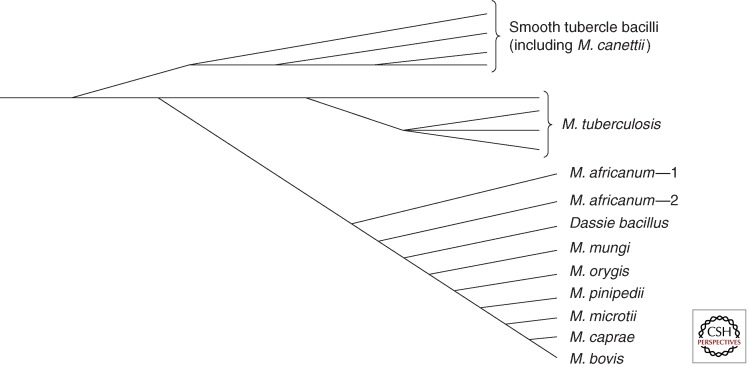

In [2]:
Image('https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4315922/bin/cshperspectmed-TUB-021204_F2.jpg')

In [ ]:
seqs=SeqIO.parse('../Morygis_hokkaido.fa','fasta')
new=[]
for s in seqs:   
    s.id=s.id.replace('.','_')
    s.seq = s.seq.upper()
    new.append(s)
SeqIO.write(new,'../myco_genomes/Morygis_hokkaido.fna',format='fasta')

In [31]:
def get_fastani(filename):
    import re
    df = pd.read_csv(filename,sep='\t',names=['query','ref','ident','x','y'])
    df['query'] = df['query'].apply(lambda x: re.split(r"[\./]+",x)[1])
    df['ref'] = df['ref'].apply(lambda x: re.split(r"[\./]+",x)[1])
    x = pd.pivot_table(df,index='query',values='ident',columns=['ref'])
    return x

In [33]:
cmd = 'fastANI --ql reference.txt --rl query.txt -o fastani.out -t 12'
#subprocess.check_output(cmd,shell=True)
anim = get_fastani('../fastani.out')
anim.to_csv('../ani_matrix.csv')

## run nucdiff

In [23]:
path = '../myco_genomes'
#names = ['Mbovis','Morygis','Mcaprae','Mmicroti','Mpinnipedii','Mcanettii','Mafricanum']
names = analysis.run_genomes(path, outpath='../myco_results')

../myco_genomes/BCG_Pasteur.fna BCG_Pasteur
../myco_genomes/Morygis_LN2011.fna Morygis_LN2011
../myco_genomes/Mcanettii.fna Mcanettii
../myco_genomes/Mpinnipedii.fna Mpinnipedii
../myco_genomes/Mmicroti.fna Mmicroti
../myco_genomes/Morygis_hokkaido.fa Morygis_hokkaido
../myco_genomes/MTB_ethiopia.fna MTB_ethiopia
../myco_genomes/Morygis_Resp2008.fna Morygis_Resp2008
../myco_genomes/Mmungi_BM22813.fna Mmungi_BM22813
../myco_genomes/Morygis_Resp2011.fna Morygis_Resp2011
../myco_genomes/Mbovis.fna Mbovis
../myco_genomes/MTB_beijing.fna MTB_beijing
../myco_genomes/Morygis_NIRTAH144.fna Morygis_NIRTAH144
../myco_genomes/Mcaprae.fna Mcaprae
../myco_genomes/Morygis_112400015.fna Morygis_112400015
../myco_genomes/Morygis_Absc2007.fna Morygis_Absc2007
../myco_genomes/Mafricanum.fna Mafricanum


## get nucdiff results
* get RD regions
* get protein annotations

In [25]:
reload(utils)
print (names)

struct, snp =  utils.get_nucdiff_results('../myco_results', names)
struct = struct[(struct.Name=='deletion') | (struct.Name=='insertion')]
struct['RD'] = struct.apply(utils.get_region,1)

subcols = ['ID','Name','start','end','length','descr','RD']
print (struct[:4][subcols])


['BCG_Pasteur', 'Morygis_LN2011', 'Mcanettii', 'Mpinnipedii', 'Mmicroti', 'Morygis_hokkaido', 'MTB_ethiopia', 'Morygis_Resp2008', 'Mmungi_BM22813', 'Morygis_Resp2011', 'Mbovis', 'MTB_beijing', 'Morygis_NIRTAH144', 'Mcaprae', 'Morygis_112400015', 'Morygis_Absc2007', 'Mafricanum']
      ID       Name   start     end  length                    descr    RD
2   SV_3  insertion   71585   71586       1    insertion_71585:71586     -
5   SV_6  insertion  150902  150903       1  insertion_150902:150903     -
7   SV_8   deletion  264754  266656    1902   deletion_264754:266656  RD10
9  SV_10  insertion  362807  362808       1  insertion_362807:362808     -


## presence/absence matrix of events

In [26]:
reload(utils)
rdmat = utils.RD_matrix(struct)
smat = utils.sites_matrix(struct, freq=4)
#snpmat = sites_matrix(snps, freq=5)


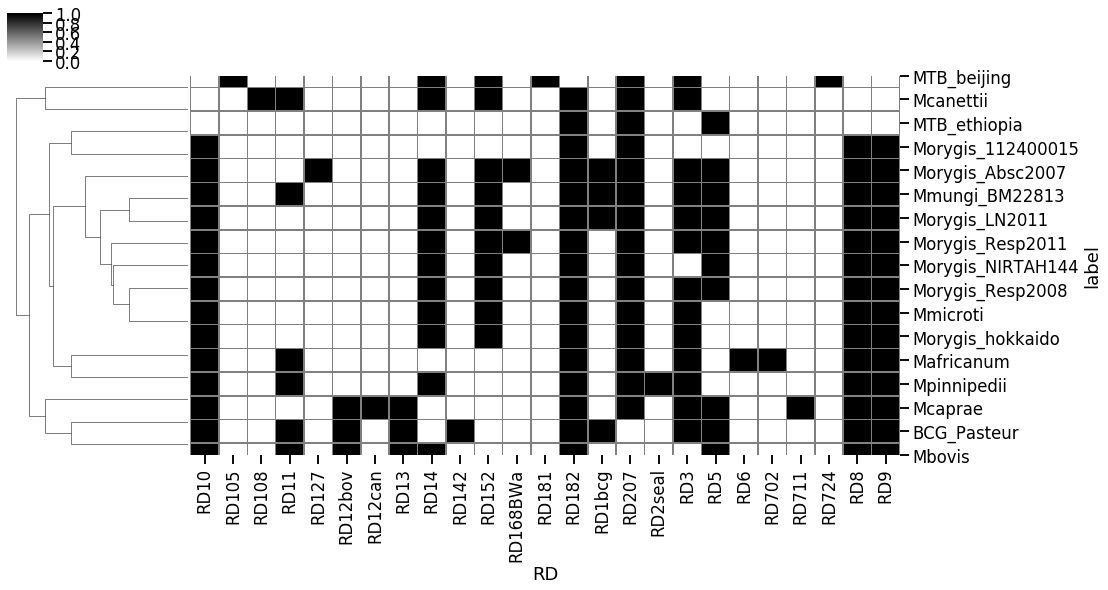

In [27]:
#x=run_RD_checker(rds)
fig = analysis.plot_RD(rdmat.T)
fig.savefig('RD_matrix.png',dpi=150)

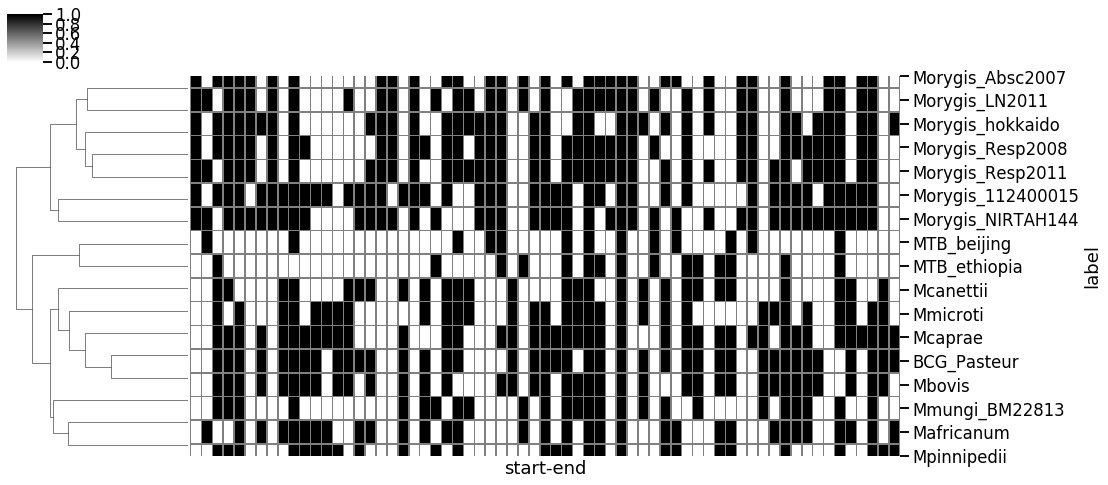

In [34]:
fig = analysis.plot_RD(smat.T)

## find RDs

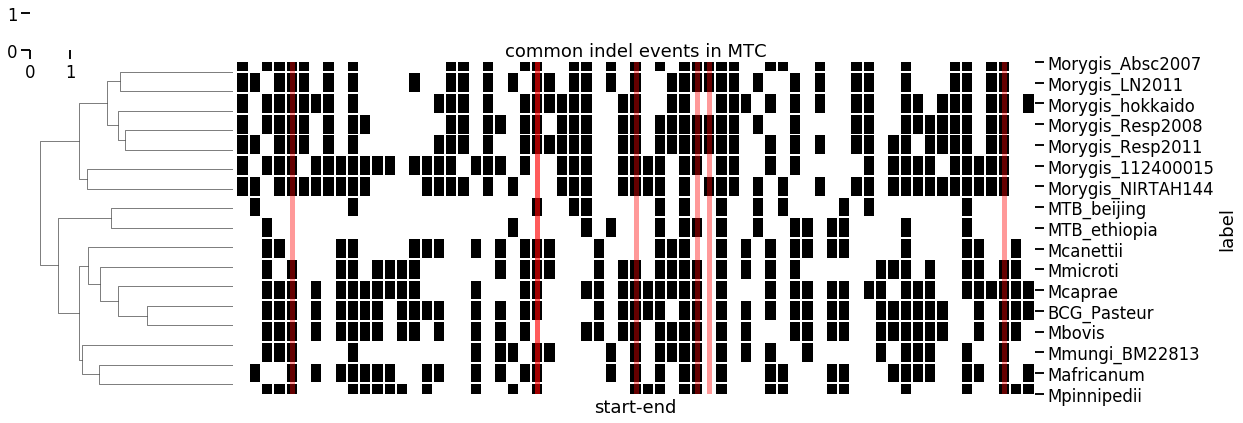

In [35]:
def map_regions(coords):
    """Map list of coords to regions of difference and return a dataframe"""
    
    m = []
    RD = pd.read_csv(utils.RD_file,comment='#')
    for c in coords:
        st,end=c
        df = RD[ (st>RD.Start) & (st<RD.Stop) |
                 ((end>RD.Start) & (end<RD.Stop)) |
                 ((st<RD.Start) & (end>RD.Stop))].copy()
        if len(df)>0:
            #print (df)            
            df['start'] = st
            df['end'] = end
            m.append(df)
    m=pd.concat(m)
    return m

m = map_regions(smat.index.values)
#get positions on heatmap of these start locs
xpos = [smat.index.get_loc(i) for i in zip(m.start,m.end)]
labels = list(m.RD_name)

#plot heatmap
g = sns.clustermap(smat.T,cbar=False,figsize=(18,7),xticklabels=False,col_cluster=False,cmap='gray_r',lw=1)
ax=g.ax_heatmap
ax.set_title('common indel events in MTC')
for x in xpos:
    ax.axvline(x=x+.5,linewidth=5,color='r',alpha=0.4)
    
plt.sca(ax)
#plt.xticks(xpos, labels)
#l=ax.set_xticklabels(labels,rotation=45)

## Compare struct changes between mbovis and orygis 

* get common start sites between the orygis and bovis samples
* common snps?

In [36]:
# changes in bovis and orygis but not in others

struct['orygis'] = struct.label.str.contains('Morygis|Mbovis').astype(int)
struct['orygis_freq'] = struct.groupby(['descr'])['orygis'].transform(np.sum)
struct['freq'] = struct.groupby(['descr'])['start'].transform(np.size)

s = struct[(struct.orygis_freq>=5) & (struct.freq<6)]
print (len(s))
s.label.value_counts()
s.descr.unique()
utils.get_summary(s)
#m = utils.sites_matrix(s, freq=1)
#fig = analysis.plot_RD(m.T)

20


,start,end,Name,freq,length,RD,gene,region_type
0,1864321,1864461,deletion,5,140,-,PE_PGRS30,PE/PPE
1,2629041,2635575,deletion,5,6534,RD5,"plcB,plcA,PPE38",known RD
2,3291398,3291399,insertion,5,1,-,None,other
3,3549075,3551229,deletion,5,2154,-,"Rv3180c,Rv3181c,Rv3182,Rv3183",other


1771
44 common sites


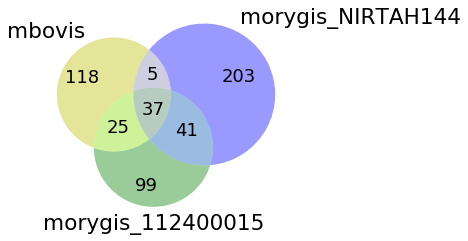

In [19]:
reload(utils)

#print (struct.label.unique())
subset = ['Mbovis', 'Morygis_NIRTAH144','Morygis_112400015','Morygis_LN2011','Morygis_Resp2011']
mb_oryg = struct[struct.label.isin(subset)]
print (len(mb_oryg))
mbdiff = struct[struct.label=='Mbovis']
modiff = struct[struct.label=='Morygis_NIRTAH144']
modiff2 = struct[struct.label=='Morygis_112400015']

from matplotlib_venn import venn3
ax=venn3((set(mbdiff.descr),set(modiff.descr),set(modiff2.descr)),
         ['mbovis','morygis_NIRTAH144','morygis_112400015'],('y','b','g'))

mat = utils.sites_matrix(mb_oryg, index='descr')
mat = mat[mat.sum(1)>3]
intersect = mat.index

comm = modiff[modiff.descr.isin(intersect)]
comm = comm[subcols]
print('%s common sites' %len(comm))
#print (comm.groupby('Name').size())

In [ ]:
comm=comm.sort_values('length',ascending=False)
comm.to_csv('morygis_common.csv')
comm

## snps in orygis

In [37]:
reload(utils)
snp_summ = utils.get_summary(snp)

In [40]:
snp_summ[snp_summ.gene=='Rv2042c']

,start,end,Name,descr,ref_bases,query_bases,freq,length,RD,gene,region_type
21795,2288568,2288569,substitution,substitution_2288568:2288569,A,C,7,1,-,Rv2042c,other


In [39]:
snp.iloc[0]

ID                               SNP_1
Name                      substitution
color                          #42C042
descr             substitution_466:467
end                                467
label                      BCG_Pasteur
length                               1
query_bases                          G
query_coord                30134-30134
query_dir                            1
query_sequence              AM408590.1
ref_bases                            A
source                    NucDiff_v2.0
start                              466
subst_len                            1
Name: 0, dtype: object